In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import math
import time
from matplotlib import pyplot

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

import datetime
import operator
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# Store the dataset
confirmed_cases = pd.read_csv("time_series_covid19_confirmed_global.csv")
cols = confirmed_cases.keys()
confirmed_case = confirmed_cases.loc[:,cols[4]:cols[-1]]

# Get a dataset with the dates and the total covid cases for that day
# ts = timeseries
confirmed_ts = confirmed_case.sum(axis=0)
confirmed_df = pd.DataFrame(confirmed_ts)

In [3]:
#Convert dates in dataframe to datetime values
confirmed_df.index.names = ["Dates"]
confirmed_df.reset_index(inplace=True)
confirmed_df.Dates = pd.to_datetime(confirmed_df.Dates)
confirmed_df['Dates'].dt.strftime('%m/%d/%Y')
confirmed_df.columns = ["Dates","Cases"]

In [4]:
confirmed_df2 = confirmed_df.set_index('Dates')

In [5]:
# Create Training and Test
train, test = train_test_split(confirmed_df2, test_size = 0.25, shuffle=False)
# x_train, x_test, y_train, y_test = train_test_split(confirmed_df2.index, confirmed_df2.Cases, test_size = 0.25, shuffle=False)

In [6]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

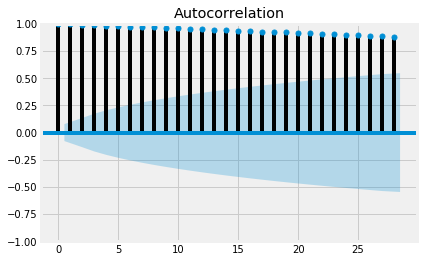

In [7]:
# Autocorrelation plot for the cases over time
plot_acf(confirmed_df.Cases)
plt.show()

In [48]:
len(confirmed_df)

630

In [8]:
# We will restructure our dataset as a supervised learning problem
# This is done by using the value at the previous time step to predict the value at the next time-step.
# Looking at the already developed function, we can easily apply it to our dataset

def create_dataset(df, previous=1):
    dataX, dataY = [], []
    for i in range(len(df)-previous-1):
        a = df.iloc[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df.iloc[i + previous, 0])
    return np.array(dataX), np.array(dataY)

In [9]:
# Create the lookback period and use the function above to get our training and testing sets
# x_lag = the number of rows we want to use to predict next
x_lag = 28
X_train, Y_train = create_dataset(train, x_lag)
X_test, Y_test = create_dataset(test, x_lag)

In [10]:
from xgboost import XGBRegressor

In [11]:
# Run the model on our training set 
model_train = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model_train.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [12]:
# Make predictions on the test data
pred_train = model_train.predict(X_test)

In [13]:
Y_test=Y_test.reshape(-1,1)
pred_train=pred_train.reshape(-1,1)

In [14]:
# look at the RMSE and MAPE
from math import sqrt
mse = mean_squared_error(Y_test, pred_train)
rmse = sqrt(mse)
mape = np.mean(np.abs(pred_train - Y_test)/np.abs(Y_test))
print('RMSE: %f' % rmse)
print("MAPE", mape)

RMSE: 52310806.006721
MAPE 0.22790276430552633


# Changing the x_lags and n_estimators to see if it reduces the RMSE


In [25]:
# Lookback period = 10
x_lag = 10
X_train, Y_train = create_dataset(train, x_lag)
X_test, Y_test = create_dataset(test, x_lag)

In [27]:
model2 = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model2.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [28]:
# Make predictions on the test data
pred2 = model2.predict(X_test)

In [29]:
Y_test=Y_test.reshape(-1,1)
pred2=pred2.reshape(-1,1)

In [30]:
# We see a drop in the RMSE with decreasing x_lags. 
# Repeat same steps with decreasing the n_estimators to use less number of trees (optimization)
mse = mean_squared_error(Y_test, pred2)
rmse = sqrt(mse)
mape = np.mean(np.abs(pred2 - Y_test)/np.abs(Y_test))
print('RMSE: %f' % rmse)
print("MAPE", mape)

RMSE: 49206183.996408
MAPE 0.20904014878406196


In [31]:
# n_estimators = 100 with lookback period = 10
x_lag = 10
X_train, Y_train = create_dataset(train, x_lag)
X_test, Y_test = create_dataset(test, x_lag)

In [32]:
model3 = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model3.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [33]:
# Make predictions on the test data
pred3 = model3.predict(X_test)

In [34]:
Y_test=Y_test.reshape(-1,1)
pred3=pred3.reshape(-1,1)

In [35]:
# There is not a significant difference. This suggests that we can use our model with 100 trees just fine to make predictions.
# When changing the n_estimators to 40, we see the RMSE rose from 49238847.67 to 49366069.707 ... 
# ... which is pretty significant. This suggests that a minimum of 50 trees should be used in building this model
mse = mean_squared_error(Y_test, pred3)
rmse = sqrt(mse)
mape = np.mean(np.abs(pred3 - Y_test)/np.abs(Y_test))
print('RMSE: %f' % rmse)
print("MAPE", mape)

RMSE: 49238847.671888
MAPE 0.20922617371536434
